# DSP - Overlap and Add Exercise
***
**Federal University of Campina Grande (Universidade Federal de Campina Grande)**

Author: **João Pedro Melquiades Gomes**

Email: **joao.melquiades@ee.ufcg.edu.br**

***
## Introduction
***

When we are processing signals in real time, we cannot process the entire signal once (convolution, fourier, etc.). Instead, we divide the signal in blocks, and apply the overlap and add method to obtain the full processed signal. The following figure illustrate this process to calculate the convolution $y[n] = x[n]*h[n]$:

![title](figures/convolution_overlap_and_add.png)

So, in this exercise I will make the convolution of the signal

<center>$x[n] = cos(\frac{2\pi n}{21})$</center>

added with noise

<center>$\eta[n] = 0.2(-1)^n\delta(n)$</center>

resulting in the signal $r[n] = x[n] + \eta[n]$

The $h[n]$ in this case will be:

<center>$h[n] = 0.5\delta(0) + 0.5\delta(1)$</center>

The parameters of the convolution:
* $M = 2^{13}$ (Size of $x[n]$);
* $L = 2$ (Size of $h[n]$);
* $M_0 = 128$ (Size of blocks).

So, let's start coding.

***
## Convolution code
***

In [1]:
# important imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set_theme()

In [2]:
# Parameters
M = 2**13
L = 2
M0 = 2**7

# Defining arrays
n = np.arange(0, M)
x = np.cos(2*np.pi*n/21)
eta = 0.2*(-1)**n*1 # 1 represents the impulse
r = x + eta
h = np.array([0.5, 0.5])

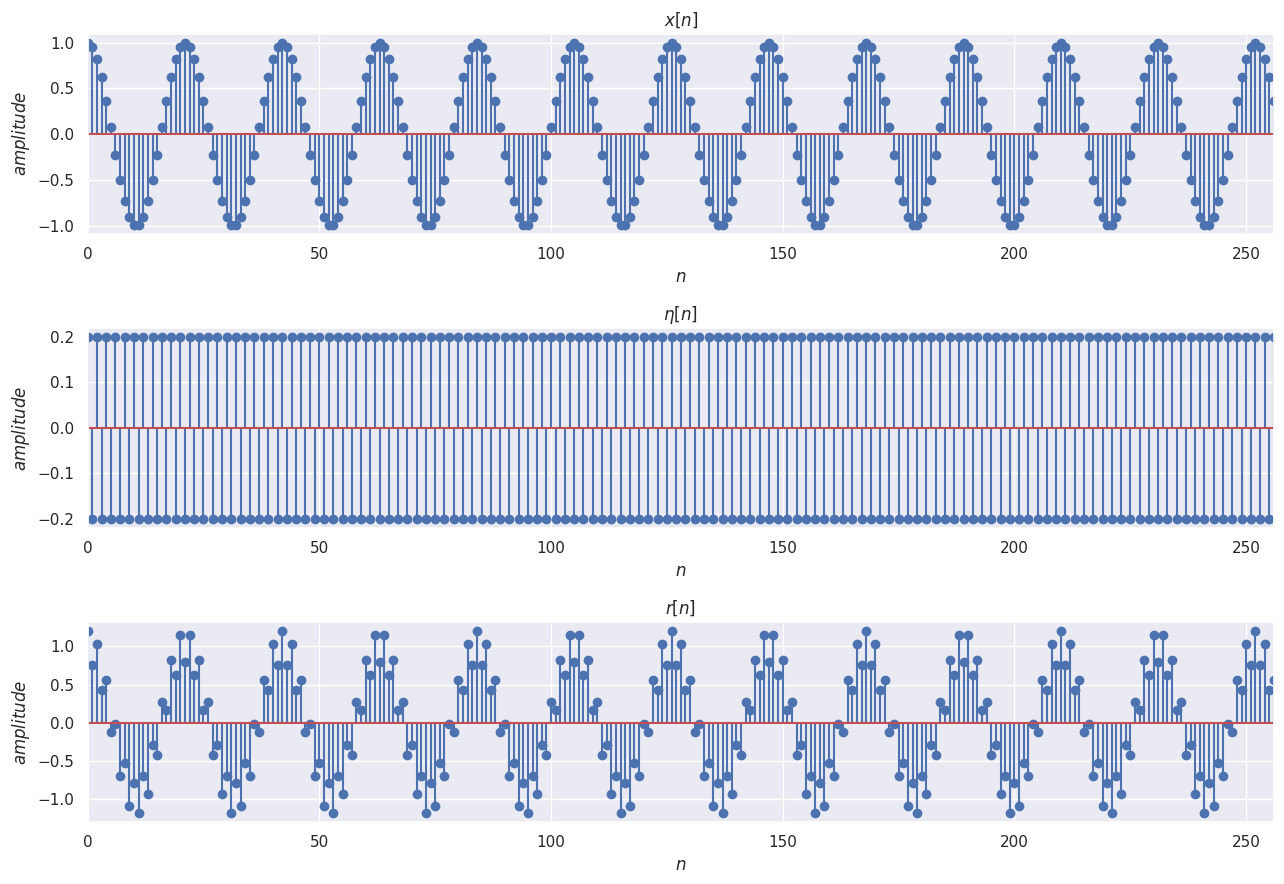

In [3]:
# plotting the signals

plt.figure(figsize=(13, 9))

plt.subplot(3, 1, 1)
plt.stem(n, x)
plt.title('$x[n]$')
plt.xlabel('$n$')
plt.ylabel('$amplitude$')
plt.xlim(0, 256)

plt.subplot(3, 1, 2)
plt.stem(n, eta)
plt.title('$\eta[n]$')
plt.xlabel('$n$')
plt.ylabel('$amplitude$')
plt.xlim(0, 256)

plt.subplot(3, 1, 3)
plt.stem(n, r)
plt.title('$r[n]$')
plt.xlim(0, 256)
plt.xlabel('$n$')
plt.ylabel('$amplitude$')
plt.tight_layout()
plt.show()

To the convolution process, the equation is:

<center>$$y_k[n] = \sum_{i=0}^{M_0+L-1}x_k[i]h[n-i]$$</center>

To transform the circular convolution in the linear convolution, I will padd with 0 both $x_k[n]$ and $h[n]$ until it reaches the size of the convolution $M_0 + L - 1$. So, the convolution can be calculated as follow:

<center>$$y_k[n] = \sum_{i=0}^{M_0+L-1}x_k[i]h[(n-i) \; mod \; (M_0 + L - 1)]$$</center>

Where the size of $y[n]$ will be $M_0 + L - 1$, as shown before

In [4]:
def round_conv(x, h):
    # padding
    yk = np.zeros(M0+L-1)
    xk = np.pad(x, (0,L-1))
    hk = np.pad(h, (0,M0-1))


    for k in range(yk.size):
        for i in range(M0+L-1):
            yk[k] += xk[i]*hk[(k - i) % (M0 + L - 1)]
    
    return yk

In [5]:
y = np.zeros(M+L-1)
yk = np.zeros(M0+L-1)

start_time = time.time()
for i in range(0, M, M0):
    yk = round_conv(x[i:i+M0], h)
    y[i:i+M0+L-1] += yk
end_time = time.time()
print(f'Time to calculate: {(end_time - start_time):.3f}s')

Time to calculate: 1.125s


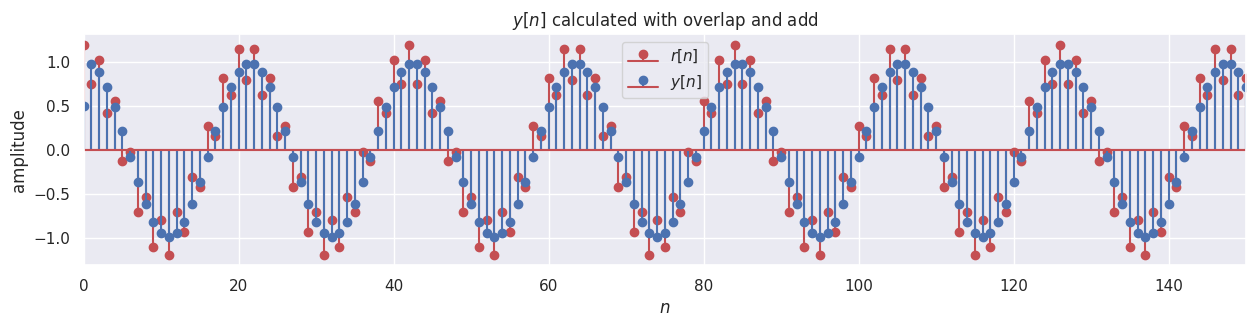

In [14]:
plt.figure(figsize=(15, 3))

plt.stem(n, r, '-r')
plt.stem(n, y[:-(L-1)]) #y[:-(L-1)] is only to plot with same size of n
plt.xlim(0, 150)
plt.xlabel('$n$')
plt.ylabel('amplitude')
plt.title('$y[n]$ calculated with overlap and add')
plt.legend(['$r[n]$', '$y[n]$'])
plt.show()


***
## Comparison with scipy
***
Let's compare with the output of `scipy.signal.convolve()`. I will create an error variable and sum all the error $y[n] - y_{scipy}[n]$. We will se that the error will be $0$!!

In [15]:
from scipy import signal

start_time = time.time()
y_scipy = signal.convolve(x, h)
end_time = time.time()

print(f'Time to calculate: {(end_time - start_time):.5f}s')

total_error = np.sum(y - y_scipy)

print(f'Total error of convolution: {total_error}')

Time to calculate: 0.00025s
Total error of convolution: 0.0


We can see that both convolutions result in same signal. Also, my implementation is extremaly less efficient compared to scipy convolution, the time to calculate show the enormous difference between the two calculations. Here, I will try to reimplement my function to achieve a better time.

***
## Trying to improve efficiency
***

The circular convolution makes $M_0 + L - 1$ multiplications for each index of $y[n]$. However, only two of these multiplications will be non-zero. So, let's reimplement the for loop making only these two multiplications

In [16]:
def improved_round_conv(x, h):
    # This time there will be no padding
    yk = np.zeros(x.size+h.size-1)

    # The first and last values are only one multiplication
    yk[0] = h[0]*x[0]
    yk[-1] = h[1]*x[-1]
    
    for i in range(1, yk.size-1):
        for j in range(h.size):
            yk[i] += x[i-1+j]*h[(h.size-1-j)]
    return yk

In [17]:
y = np.zeros(M+L-1)
yk = np.zeros(M0+L-1)

start_time = time.time()
for i in range(0, M, M0):
    yk = improved_round_conv(x[i:i+M0], h)
    y[i:i+M0+L-1] += yk
end_time = time.time()
print(f'Time to calculate: {(end_time - start_time):.3f}s')

Time to calculate: 0.026s


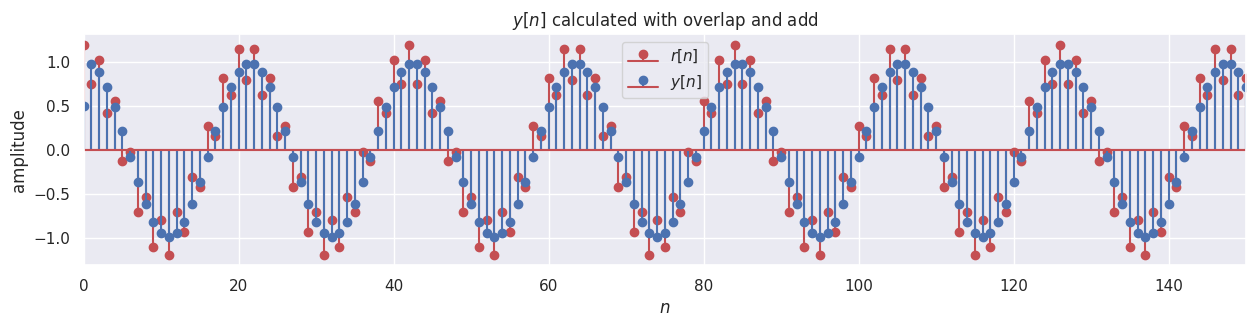

In [18]:
plt.figure(figsize=(15, 3))

plt.stem(n, r, '-r')
plt.stem(n, y[:-(L-1)]) #y[:-(L-1)] is only to plot with same size of n
plt.xlim(0, 150)
plt.xlabel('$n$')
plt.ylabel('amplitude')
plt.title('$y[n]$ calculated with overlap and add')
plt.legend(['$r[n]$', '$y[n]$'])
plt.show()


In [19]:
total_error = np.sum(y - y_scipy)

print(f'Total error of convolution: {total_error}')

Total error of convolution: 0.0


The error remains zero. This time, my new algorithm took less than $0.015s$ to compute the convolution. It's still much less efficient than the scipy method, but when comparing with the old implementation, the time reduction is incredible, only ignoring the zero multiplications.